In [1]:

import os
import cv2
import numpy as np
import sys

sys.path.append('../')

import torchlm
# from torchlm.tools import faceboxesv2
# from torchlm.models import pipnet

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import warnings 
# from cfg import *
# from tools import *

# from torch_affine_ops import *
from tensor_processing import *
warnings.filterwarnings("ignore")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def read_video_np(video_path):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    H, W = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print('video length: ', length)
    print('video size: ','H--', H, 'W--',W)
    

    frames = []
    frames_id = 1
    while True:
        ret, frame = cap.read()
        if ret:
            frames_id += 1 
            if frames_id%50==0:
                frames.append(frame)
        else:
            break
    cap.release()
    return frames


In [4]:
video_path = '../template/2243_1695388988.mp4'
video_frames = read_video_np(video_path)
video_frames = np.array(video_frames, dtype=np.float32)
video_frames = video_frames[:, :, :, ::-1] # BGR to RGB



video length:  1439
video size:  H-- 368 W-- 640


In [5]:
device.__str__()

'cuda'

In [6]:
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

torchlm.runtime.bind(faceboxesv2(device=device))  # set device="cuda" if you want to run with CUDA
# set map_location="cuda" if you want to run with CUDA
torchlm.runtime.bind(
  pipnet(backbone="resnet18", pretrained=True,  
         num_nb=10, num_lms=68, net_stride=32, input_size=256,
         meanface_type="300w", map_location=device.__str__(), checkpoint=None) 
) # will auto download pretrained weights from latest release if pretrained=True
landmarks, bboxes = torchlm.runtime.forward(video_frames[0])


landmarks_list = []
bboxes_list = []
for i in range(len(video_frames)):
    landmarks, bboxes = torchlm.runtime.forward(video_frames[i])
    trust = bboxes[:,4]
    faithful_index = np.argsort(trust)[-1]
    landmarks_list.append(landmarks[faithful_index,:,:])
    bboxes_list.append(bboxes[faithful_index,:])

landmarks_list = np.array(landmarks_list)
bboxes_list = np.array(bboxes_list)






In [33]:
# input_shape2 = B*3*192*192

feed_img = torch.tensor(video_frames.copy(),device=device).float()
feed_img = feed_img.permute(0,3,1,2)

# bbox = torch.from_numpy(bboxes_list[:,:4]).float().to(device)
landmarks_tensor = torch.from_numpy(landmarks_list).to(device)

# center = (bbox[:,0:2] + bbox[:,2:4])/2

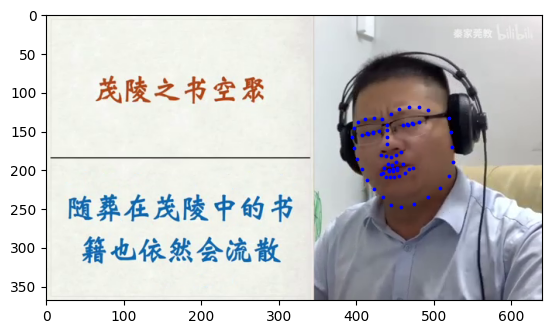

In [34]:
layer_index = -2
plt.imshow(feed_img[layer_index].permute(1,2,0).cpu().numpy().astype(np.uint8))
plt.scatter(landmarks_tensor[layer_index,:,0].cpu().numpy(), landmarks_tensor[layer_index,:,1].cpu().numpy(), c='b', s=3)
# plt.scatter(center[layer_index,0].cpu().numpy(), center[layer_index,1].cpu().numpy(), c='r', s=20, marker='*')

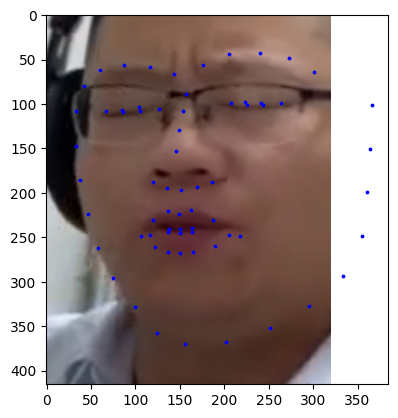

In [47]:
facealigner = FaceAlign(ratio=1.6, device=device)
face_align_img, lmrks_align, face_align_matrix = facealigner(feed_img, landmarks_tensor,out_W=320)
lmrks_align_np = lmrks_align.cpu().numpy()
plt.imshow(face_align_img[layer_index].permute(1,2,0).cpu().numpy().astype(np.uint8))
plt.scatter(lmrks_align_np[layer_index,:,0], lmrks_align_np[layer_index,:,1], c='b', s=3)

In [48]:
smoothmasker = SmoothMask(radius=15,sigma=4,padding='same')
smoothmasker = smoothmasker.to(device)  

masked_output = smoothmasker(face_align_img.to(device), lmrks_align.to(device))

364

In [49]:
from torchvision import transforms

In [50]:
transforms.Resize

torchvision.transforms.transforms.Resize

In [51]:
class SmoothMask(nn.Module):
  def __init__(self, radius=15,sigma=4,padding='same'):
    super(SmoothMask, self).__init__()
    self.gaussian_bluringer = Gaussian_bluring(radius=radius,sigma=sigma,padding=padding)
    # self.bias = bias
    # self.scaling = scaling
    self.standard_shape = (364, 280)
    self.standard_resizer = transforms.Resize(self.standard_shape)
    

  def forward(self, input_face, landmarks, filling='black'):
    """
    input_face: B*3*H*W
    landmarks: B*68*2
    """
    B, C, H, W = input_face.shape
    
    device = input_face.device
    scaling = self.standard_shape[0]/H
    
    landmarks_standard = landmarks*scaling 


    landmarks_keys_part0 = landmarks_standard[...,range(30,36),:] #
    landmarks_keys_part1 = landmarks_standard[...,range(2,15),:] #
    landmarks_keys_part2 = landmarks_standard[...,range(48,68),:] # 
    landmarks_keys_part3 = landmarks_standard[...,range(6,11),:] #
    landmarks_center = landmarks_standard[...,30:31,:]#

    landmarks_keys_part01 = (landmarks_keys_part0 - landmarks_center)*1.5 + landmarks_center
    landmarks_keys_part11 = (landmarks_keys_part1 - landmarks_center)*0.5 + landmarks_center
    landmarks_keys_part12 = (landmarks_keys_part1 - landmarks_center)*0.7 + landmarks_center
    landmarks_keys_part13 = (landmarks_keys_part1 - landmarks_center)*0.9 + landmarks_center
    #landmarks_keys_part14 = (landmarks_keys_part1 - landmarks_center)*1.1 + landmarks_center
    landmarks_keys_part21 = (landmarks_keys_part2 - landmarks_center)*1.3 + landmarks_center

    landmarks_keys = torch.cat((landmarks_keys_part0,landmarks_keys_part01,landmarks_keys_part12, landmarks_keys_part13,landmarks_keys_part11,landmarks_keys_part2,landmarks_keys_part3,landmarks_keys_part21),axis=-2)

    landmarks_index_Y_test = torch.clip(landmarks_keys[...,1], 0, 363).round().type(torch.LongTensor).to(device)
    landmarks_index_X_test = torch.clip(landmarks_keys[...,0], 0, 279).round().type(torch.LongTensor).to(device)

    heatmap_mask = torch.zeros((B,1,self.standard_shape[0],self.standard_shape[1])).to(device)
    
    heatmap_mask[...,landmarks_index_Y_test,landmarks_index_X_test] = 1
    # diffusion the landmarks to the masked area
    w_mask = self.gaussian_bluringer(heatmap_mask) 


    w_mask[(w_mask > 1e-7)] = 1
    

    w_mask = self.gaussian_bluringer(w_mask)
    
    resizer = transforms.Resize((H,W))

    w_mask = resizer(w_mask)

    w_origin = 1 - w_mask

    if filling == 'black':
      masked_output =  w_origin*input_face  #+ w_mask*torch.zeros_like(input_face)

    if filling == 'mean':
      
      masked_output =  w_origin*input_face  + w_mask*torch.mean(input_face,dim=[-1,-2],keepdim=True)

    return masked_output

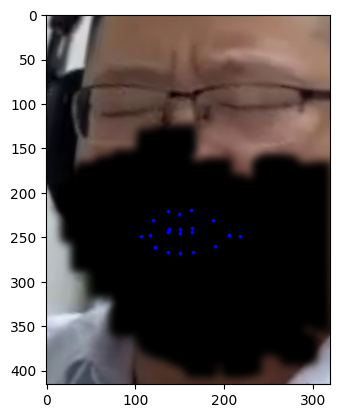

In [52]:
smoothmasker = SmoothMask(radius=15,sigma=4,padding='same')
smoothmasker = smoothmasker.to(device)  

masked_output = smoothmasker(face_align_img.to(device), lmrks_align.to(device))

plt.imshow(masked_output[layer_index].permute(1,2,0).cpu().numpy().astype(np.uint8))
plt.scatter(lmrks_align_np[layer_index,48:68,0], lmrks_align_np[layer_index,48:68,1], c='b', s=3)

In [ ]:
source_image_data = cv2.imread(source_image_path_list[source_frame_index])[:, :, ::-1]
source_image_mask = source_image_data / 255.0  # 针对实验1的要求只做了归一化 不做resize 实验1不要resize 取代origin 用smoothmask时调用

# source_image_data = cv2.resize(source_image_data, (self.img_w, self.img_h)) / 255.0  # 做了归一化 #origin original 采用smoothmask时也要保留

source_clip_list.append(source_image_data)
# source_image_mask = source_image_data.copy() #origin original 采用smoothmask时注释掉

####### original采用smoothmask时注释掉
source_image_mask_alpha = np.zeros_like(source_image_data[:,0:1,...])
source_image_mask_alpha[:,:,self.radius:self.radius + self.mouth_region_size,self.radius_1_4:self.radius_1_4 + self.mouth_region_size, :] = 0

mask_gaussian = Gaussian_bluring(radius=10,sigma=4,padding='same')

# source_clip B*3*H*W
source_image_mask_alpha = np.zeros_like(source_clip[:,0:1,...])
source_image_mask_alpha[:,:,H0:H1,W0:W1] = 1
source_image_mask_alpha = mask_gaussian(source_image_mask_alpha)

source_clip_mask = source_clip*(1.0-source_image_mask_alpha)



source_image_mask[self.radius:self.radius + self.mouth_region_size,
                  self.radius_1_4:self.radius_1_4 + self.mouth_region_size, :] = 0

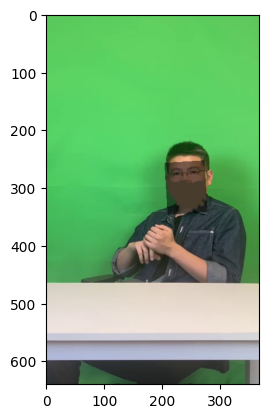

In [15]:
reform_img = facealigner.recover(masked_output/2, feed_img, face_align_matrix)

reform_img_np = reform_img.permute(0,2,3,1).cpu().numpy().astype(np.uint8)

plt.imshow(reform_img_np[layer_index])

In [ ]:
# def warp_img_torch(img, transform_matrix, output_size):

#     # please pay exact attention on the order of H and W,
#     # and the normalization of the grid in Torch, but not in OpenCV
#     device = img.device
#     B, C, H, W = img.shape
#     T = torch.Tensor([[2 / (W-1), 0, -1],
#               [0, 2 / (H-1), -1],
#               [0, 0, 1]]).to(device).repeat(B,1,1)
    
#     T2 = torch.Tensor([[2 / (output_size[1]-1), 0, -1],[0, 2 / (output_size[0]-1), -1],[0, 0, 1]]).to(device).repeat(B,1,1)
#     M_torch = torch.matmul(T2,torch.matmul(transform_matrix,torch.linalg.inv(T)))
#     grid_trans = torch.linalg.inv(M_torch)[:,0:2,:]

#     grid = F.affine_grid(grid_trans, torch.Size((B, C, output_size[0], output_size[1])))
#     img = F.grid_sample(img, grid)
#     return img

# class FaceAlign(nn.Module):
  
#   def __init__(self, ratio=2, device='cuda'):
#     super(FaceAlign, self).__init__()

#     self.list68to25 = list(range(17,37))+[39,42,45,48,54]


#     self.standard_lm_25 = torch.tensor([[2.13256e-04, 1.06454e-01],
#        [7.52622e-02, 3.89150e-02],
#        [1.81130e-01, 1.87482e-02],
#        [2.90770e-01, 3.44891e-02],
#        [3.93397e-01, 7.73906e-02],
#        [5.86856e-01, 7.73906e-02],
#        [6.89483e-01, 3.44891e-02],
#        [7.99124e-01, 1.87482e-02],
#        [9.04991e-01, 3.89150e-02],
#        [9.80040e-01, 1.06454e-01],
#        [4.90127e-01, 2.03352e-01],
#        [4.90127e-01, 3.07009e-01],
#        [4.90127e-01, 4.09805e-01],
#        [4.90127e-01, 5.15625e-01],
#        [3.66880e-01, 5.87326e-01],
#        [4.26036e-01, 6.09345e-01],
#        [4.90127e-01, 6.28106e-01],
#        [5.54217e-01, 6.09345e-01],
#        [6.13373e-01, 5.87326e-01],
#        [1.21737e-01, 2.16423e-01],
#        [3.34606e-01, 2.31733e-01],
#        [6.45647e-01, 2.31733e-01],
#        [8.58516e-01, 2.16423e-01],
#        [2.54149e-01, 7.80233e-01],
#        [7.26104e-01, 7.80233e-01]], device=device).float()


#     up = (self.standard_lm_25[2,:]+ self.standard_lm_25[7,:])/2
#     mark = self.standard_lm_25[12,:]
#     scale = (mark-up)[1]
#     center = up + (mark- up)*6.5/4
#     center[0] = mark[0]
#     self.standard_lm_25 -= center
#     self.standard_lm_25 /= ratio*scale 


#   def Face_align_matrix(self, landmarks_tensor, out_W = 280):
    
#     device = landmarks_tensor.device

#     B = landmarks_tensor.shape[0]
#     out_H = out_W*1.3

#     lmrks_25 = landmarks_tensor[:,self.list68to25,:].view(-1,25,2)
    
#     stand_lm_25 = self.standard_lm_25.clone()

#     stand_lm_25 *= out_W/2
#     stand_lm_25 = stand_lm_25.to(device)
#     stand_lm_25 += torch.tensor([out_W/2, out_H/2],device=device).float()

#     Similarity_Matrix_3d_final = SimilarityTransform_torch_2D(lmrks_25, stand_lm_25.repeat(B,1,1))

#     return Similarity_Matrix_3d_final

#   def forward(self, feed_img, landmarks_tensor, out_W = 280):
    
#     face_align_matrix = self.Face_align_matrix(landmarks_tensor, out_W = out_W)

#     face_align_img = warp_img_torch(feed_img, face_align_matrix, (int(1.3*out_W), int(out_W)))

#     face_align_img = torch.clip(face_align_img, 0, 255)

#     face_align_img = torch.clip(face_align_img, 0, 255)

#     lmrks_align = torch.matmul(landmarks_tensor,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,-1:].transpose(-1,-2)

#     return face_align_img, lmrks_align, face_align_matrix


#   def recover(self, fake_part, origin_img, face_align_matrix):

#     B, C, H, W = origin_img.shape

#     device = origin_img.device

#     output_size = fake_part.shape[-2:]

#     output_size_tensor = torch.tensor(output_size,device=device).float()

#     face_align_matrix_inversed = torch.inverse(face_align_matrix)

#     # grid = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:].repeat(B,1,1), torch.Size((B, C, output_size, output_size)))
#     grid = standard_grid(output_size,B,device=device)

#     grid_index = (grid + 1.0-1.0/output_size_tensor.flip(-1))*(output_size_tensor.flip(-1)-1)/(2-2/output_size_tensor.flip(-1))
#     grid_index_reversed = torch.matmul(grid_index.view(B,-1,2),face_align_matrix_inversed[:,:2,:2].transpose(-1,-2)) + face_align_matrix_inversed[:,:2,-1:].transpose(-1,-2)
#     grid_index_reversed = grid_index_reversed.view(B,output_size[0],output_size[1],2).long()

  
#     #lmrks_align_reversed_np = lmrks_align_reversed[layer_index].cpu().numpy()

#     reform_img_2 = origin_img.permute(1,0,2,3).contiguous()

#     grid_index_reversed_2 = torch.cat([torch.range(0,B-1,device=device).long().view(B,1,1,1).repeat(1,output_size[0],output_size[1],1),grid_index_reversed],dim=-1)

#     index_set = (grid_index_reversed_2[...,0],
#                 grid_index_reversed_2[...,2],
#                 grid_index_reversed_2[...,1])

#     new_value = fake_part.permute(1,0,2,3)


#     for i in range(channel:=3):
#         reform_img_2[i] = reform_img_2[i].index_put(index_set, new_value[i]) 

#     # reform_img_2[:,grid_index_reversed_2[:,:,:,2],grid_index_reversed_2[:,:,:,1], grid_index_reversed_2[:,:,:,0]] = fake_img.permute(1,0,2,3)

#     reform_img = reform_img_2.permute(1,0,2,3)

#     return reform_img
    
    

